In [1]:
import os, glob, json
for folder in glob.glob("chloeli_stream-of-search-countdown-10k/*"):
    for file in glob.glob(f"{folder}/qwen*"):
        # read as json
        with open(file, "r") as f:
            data = json.load(f)
            print(data)
        break


[{'hyperparams': {'seed': 4, 'ckpt': None, 'adapter': 'chloeli/qwen-2.5-0.5b-instruct-sft-qlora-countdown-search-1k', 'num': 256, 'offset': 0, 'data_dir': '', 'data': 'chloeli/stream-of-search-countdown-10k', 'temperature': 0.0, 'batch_size': 64, 'ctx': 4096, 'gens': 1, 'split_range': '0:6', 'chat_template': True}}, {'trial_success_rates': [0.1328125], 'best_of_n': 0.1328125, 'mean': 0.1328125}, [{'prompt': 'Make 96 with the numbers [58, 84, 48, 62] using standard arithmetic operations.', 'completion': "system\nYou are Qwen, created by Alibaba Cloud. You are a helpful assistant.\nuser\nMake 96 with the numbers [58, 84, 48, 62] using standard arithmetic operations.\nassistant\nCurrent State: 96:[58, 84, 48, 62], Operations: []\nExploring Operation: 58+48=106, Resulting Numbers: [84, 62, 106]\nGenerated Node #0,0: 96:[84, 62, 106] Operation: 58+48=106\nMoving to Node #0,0\nCurrent State: 96:[84, 62, 106], Operations: ['58+48=106']\nExploring Operation: 84-62=22, Resulting Numbers: [106, 

In [4]:
run_details

{}

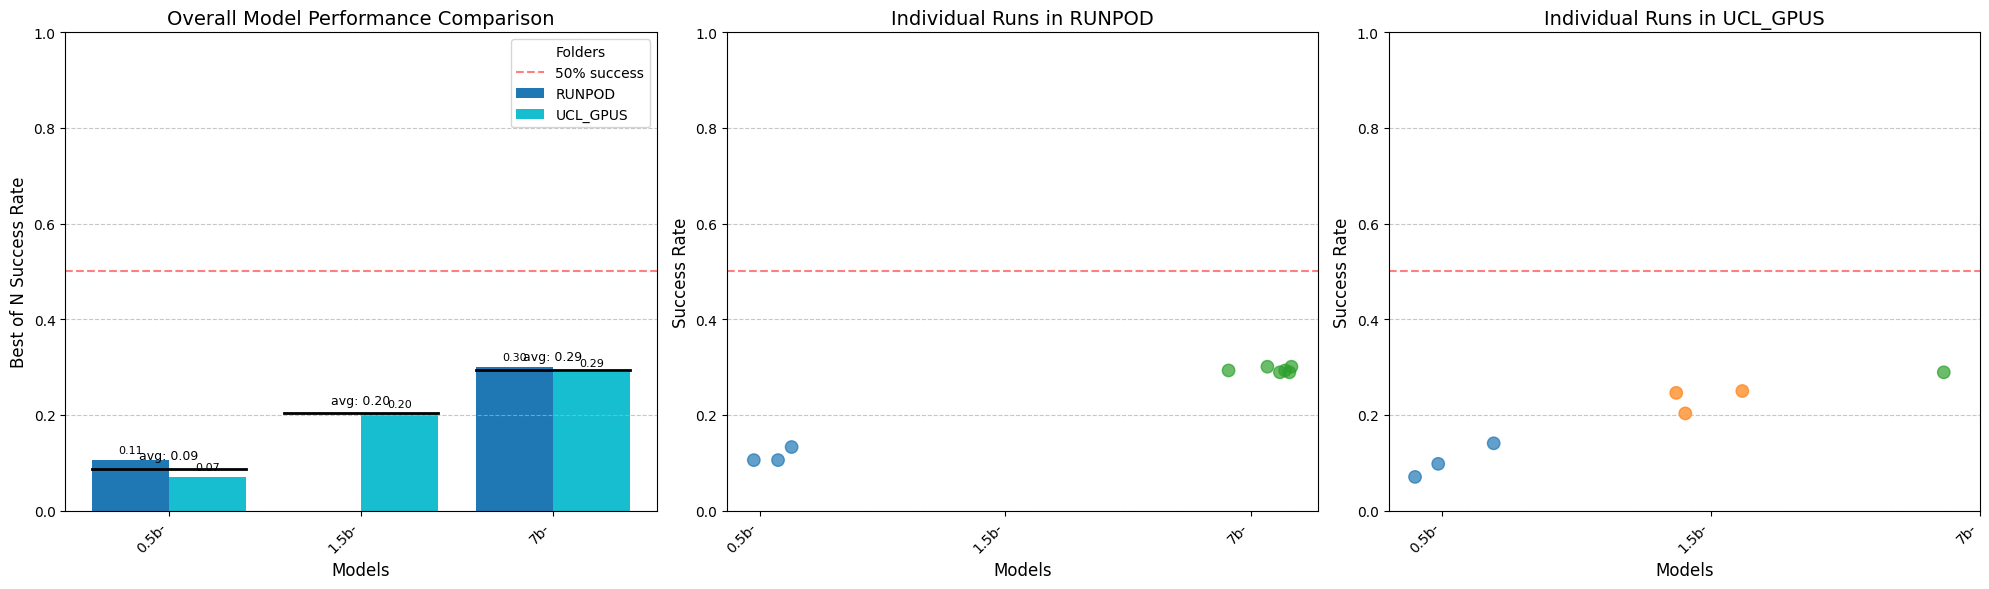

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import json
import glob
import os

folders = [folder for folder in glob.glob("chloeli_stream-of-search-countdown-10k/*") if os.path.isdir(folder)]

# Dictionary to store data by model and folder
data_by_model = {}
# Store individual run data
run_details = {}

for folder in folders:
    folder_name = os.path.basename(folder)
    
    for file in glob.glob(f"{folder}/qwen*"):
        with open(file, "r") as f:
            data = json.load(f)
        
        hyperparams = data[0]['hyperparams']
        best_of_n = data[1]['best_of_n']
        model_name = hyperparams['adapter'].split("instruct")[0].split("2.5-")[-1]
        
        # # Store individual run results if available
        # if 'results' in data[1]:
        run_id = f"{model_name}_{folder_name}_{os.path.basename(file)}"
        #     run_details[run_id] = {
        #         'model': model_name,
        #         'folder': folder_name,
        #         'results': data[1]['results'],
        #         'file': os.path.basename(file),
        #         'success_rate': best_of_n
        #     }
        run_details[run_id] = {
            "success_rate": best_of_n,
            "model": model_name,
            "folder": folder_name,
            "file": os.path.basename(file)
        }
        if model_name not in data_by_model:
            data_by_model[model_name] = {}
        
        data_by_model[model_name][folder_name] = best_of_n

# Get unique model names and folder names
models = sorted(data_by_model.keys())
folder_names = sorted(set(folder for model_data in data_by_model.values() for folder in model_data.keys()))

# Create a figure with 3 subplots (1 row, 3 columns)
fig = plt.figure(figsize=(20, 6))

# 1. Overall Comparison Plot (first subplot)
ax_main = plt.subplot(1, 3, 1)

# Set up the bar chart
x = np.arange(len(models))
width = 0.8 / len(folder_names)  # Width of each bar
colors = plt.cm.tab10(np.linspace(0, 1, len(folder_names)))

# Plot bars for each folder
for i, folder in enumerate(folder_names):
    values = [data_by_model[model].get(folder, 0) for model in models]
    bars = ax_main.bar(x + i*width - (len(folder_names)-1)*width/2, values, 
                       width=width, label=folder, color=colors[i])
    
    # Add value labels
    for bar, value in zip(bars, values):
        height = bar.get_height()
        if height > 0:  # Only label non-zero bars
            ax_main.text(bar.get_x() + bar.get_width()/2, height + 0.01,
                        f"{value:.2f}", ha='center', va='bottom', 
                        fontsize=8)

# Calculate average success rate per model
model_avg = {model: np.mean([value for value in data_by_model[model].values()]) 
             for model in models}

# Plot average line
avg_values = [model_avg[model] for model in models]
for i, (x_pos, y_pos) in enumerate(zip(x, avg_values)):
    ax_main.plot([x_pos-0.4, x_pos+0.4], [y_pos, y_pos], color='black', linestyle='-', linewidth=2)
    ax_main.text(x_pos, y_pos + 0.02, f"avg: {y_pos:.2f}", ha='center', fontsize=9)

# Configure the plot
ax_main.set_xlabel('Models', fontsize=12)
ax_main.set_ylabel('Best of N Success Rate', fontsize=12)
ax_main.set_title('Overall Model Performance Comparison', fontsize=14)
ax_main.set_xticks(x)
ax_main.set_xticklabels(models, rotation=45, ha='right', fontsize=10)
ax_main.set_ylim(0, 1)
ax_main.grid(axis='y', linestyle='--', alpha=0.7)
ax_main.axhline(y=0.5, color='r', linestyle='--', alpha=0.5, label="50% success")
ax_main.legend(title='Folders', loc='upper right')

# Group run details by folder
runs_by_folder = {}
for run_id, details in run_details.items():
    folder = details['folder']
    if folder not in runs_by_folder:
        runs_by_folder[folder] = []
    runs_by_folder[folder].append(details)

# Map model names to numeric indices for scatter plot x-positions
model_indices = {model: i for i, model in enumerate(models)}

# 2. Scatter plot for the first folder
if len(folder_names) > 0:
    first_folder = folder_names[0]
    ax_folder1 = plt.subplot(1, 3, 2)
    
    if first_folder in runs_by_folder:
        folder_runs = runs_by_folder[first_folder]
        
        # Prepare data for scatter plot
        x_positions = []
        y_values = []
        colors_list = []
        
        for run in folder_runs:
            model = run['model']
            if model in model_indices:
                x_pos = model_indices[model]
                x_positions.append(x_pos)
                y_values.append(run['success_rate'])
                colors_list.append(plt.cm.tab10(model_indices[model] % 10))
        
        # Add some jitter to x positions
        x_jittered = [x + np.random.uniform(-0.2, 0.2) for x in x_positions]
        
        # Create scatter plot
        ax_folder1.scatter(x_jittered, y_values, c=colors_list, alpha=0.7, s=80)
        
        # Configure the plot
        ax_folder1.set_xlabel('Models', fontsize=12)
        ax_folder1.set_ylabel('Success Rate', fontsize=12)
        ax_folder1.set_title(f'Individual Runs in {first_folder}', fontsize=14)
        ax_folder1.set_xticks(range(len(models)))
        ax_folder1.set_xticklabels(models, rotation=45, ha='right', fontsize=10)
        ax_folder1.set_ylim(0, 1)
        ax_folder1.grid(axis='y', linestyle='--', alpha=0.7)
        ax_folder1.axhline(y=0.5, color='r', linestyle='--', alpha=0.5)
    else:
        ax_folder1.text(0.5, 0.5, f"No run details available for {first_folder}", 
                     ha='center', va='center')
        ax_folder1.set_title(f'{first_folder}', fontsize=14)
        ax_folder1.axis('off')

# 3. Scatter plot for the second folder
if len(folder_names) > 1:
    second_folder = folder_names[1]
    ax_folder2 = plt.subplot(1, 3, 3)
    
    if second_folder in runs_by_folder:
        folder_runs = runs_by_folder[second_folder]
        
        # Prepare data for scatter plot
        x_positions = []
        y_values = []
        colors_list = []
        
        for run in folder_runs:
            model = run['model']
            if model in model_indices:
                x_pos = model_indices[model]
                x_positions.append(x_pos)
                y_values.append(run['success_rate'])
                colors_list.append(plt.cm.tab10(model_indices[model] % 10))
        
        # Add some jitter to x positions
        x_jittered = [x + np.random.uniform(-0.2, 0.2) for x in x_positions]
        
        # Create scatter plot
        ax_folder2.scatter(x_jittered, y_values, c=colors_list, alpha=0.7, s=80)
        
        # Configure the plot
        ax_folder2.set_xlabel('Models', fontsize=12)
        ax_folder2.set_ylabel('Success Rate', fontsize=12)
        ax_folder2.set_title(f'Individual Runs in {second_folder}', fontsize=14)
        ax_folder2.set_xticks(range(len(models)))
        ax_folder2.set_xticklabels(models, rotation=45, ha='right', fontsize=10)
        ax_folder2.set_ylim(0, 1)
        ax_folder2.grid(axis='y', linestyle='--', alpha=0.7)
        ax_folder2.axhline(y=0.5, color='r', linestyle='--', alpha=0.5)
    else:
        ax_folder2.text(0.5, 0.5, f"No run details available for {second_folder}", 
                     ha='center', va='center')
        ax_folder2.set_title(f'{second_folder}', fontsize=14)
        ax_folder2.axis('off')

plt.tight_layout()
plt.savefig("model_comparison.png")
plt.show()